In [556]:
from graphviz import Digraph, nohtml
from bisect import insort_left, bisect_left
from math import floor

# Arbres-B - Version 1
Sources : Sedgewick Wayne - Algorithms 4th edition et cours d'Algav

Pour un arbre d'ordre m:
- Noeuds : m <= k <= 2m clés
- Racine : 1 <= k <= 2m clés

# Table des matières <a class="anchor" id="menu"></a>
* [Graphviz](#graphviz)
* [Arbre-B et PageB V1](#btree1)
* [Tests](#tests)
<!-- * [Arbre-B et PageB V2](#btree2) -->

## Graphviz <a class="anchor" id="graphviz"></a>                                                                                                                                  
#### [Retour](#menu) 

In [557]:
def visualiser_arbre(arbreB):
    # dot = Digraph()
    dot = Digraph(node_attr={'shape': 'record', 'height': '.1'})
    index = 0

    def bufferNoeud(cles):
        buffer = "<f0> |"
        for i in range(len(cles)):
            buffer += "<f" + str(2*i+1) + "> " + str(cles[i]) + "|" # case cle : indice impair
            if i != len(cles)-1:
                buffer += "<f" + str(2*i+2) + "> " + "|" # case pointeur vers enfant : indice pair
            else:
                buffer += "<f" + str(2*i+2) + "> "
        return buffer

        # for i in range(1,nbCases):
        #     if i % 2 == 1: # cle
        #         buffer += "<f" + str(i) + "> " + str(cles[i]) + "|"
        #     else:
        #         buffer += "<f" + str(i) + "> " + "|"
        # # buffer += "<f" + str(nbCases) + "> " + str(cles[-1]) # derniere cle sans le "|"
        # return buffer


        # if cle is None:
        #     buffer += "<f" + str(indice) + "> "
        # else:
        #     buffer += "<f" + str(indice) + "> " + str(cle)
        # if not estDerniereCle:
        #     buffer += "|"
        # return buffer
    
    def traverse(pageB):
        nonlocal index

        if pageB is None:
            return

        buffer = bufferNoeud(pageB.cles)
        dot.node(str(index), nohtml(buffer))
        # index += 1
        
        idParent = index
        for i in range(len(pageB.enfants)):
            parent = str(idParent) + ":f" + str(2*i)
            index += 1
            enfant = str(index)
            dot.edge(parent, enfant)
            traverse(pageB.enfants[i])
    
    traverse(arbreB.racine)
    return dot

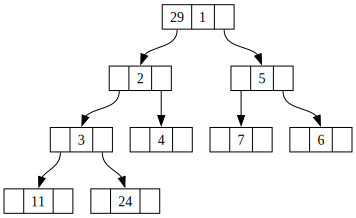

In [558]:
# test graphviz - source : https://graphviz.readthedocs.io/en/stable/examples.html#btree-py

g = Digraph(node_attr={'shape': 'record', 'height': '.1'})

g.node('node0', nohtml('<f0> 29|<f1> 1|<f2>'))
g.node('node1', nohtml('<f0> |<f1> 2|<f2>'))
g.node('node2', nohtml('<f0> |<f1> 3|<f2>'))
g.node('node3', nohtml('<f0> |<f1> 4|<f2>'))
g.node('node4', nohtml('<f0> |<f1> 5|<f2>'))
g.node('node5', nohtml('<f0> |<f1> 7|<f2>'))
g.node('node6', nohtml('<f0> |<f1> 6|<f2>'))
g.node('node7', nohtml('<f0> |<f1> 11|<f2>'))
g.node('node8', nohtml('<f0> |<f1> 24|<f2>'))

g.edge('node0:f2', 'node4:f1')
g.edge('node0:f0', 'node1:f1')
g.edge('node1:f0', 'node2:f1')
g.edge('node1:f2', 'node3:f1')
g.edge('node2:f2', 'node8:f1')
g.edge('node2:f0', 'node7:f1')
g.edge('node4:f2', 'node6:f1')
g.edge('node4:f0', 'node5:f1')

g

## Arbre-B et PageB <a class="anchor" id="btree"></a>                                                                                                                                  
#### [Retour](#menu) 

In [559]:
class PageB:
    def __init__(self, cles):
        self.cles = cles # nbCles noeud : entre m/2 et m-1, nbCles racine : entre 2 et m-1
        self.enfants = []
        self.parent = None
        # self.estExterne = estExterne

    def estPageVide(self): # peut-etre utile ?
        return self.cles == []

    def estPageExterne(self):
        """ Retourne true si self est une page externe (feuille).
        """
        return len(self.enfants) == 0
    
    def estPageDebordement(self, nbMaxCles):
        return len(self.cles) > nbMaxCles

    def recherchePage(self, cle):
        """ Retourne true si cle est dans la page self.
        """
        return cle in self.cles
    
    def indicePageSuivante(self, cle):
        """ Retourne l'indice de la page suivante (enfant de la page self) qui pourrait
            contenir la cle cle.
            Hypothese : self n'est pas une page externe (sinon pas de page suivante)
            (hypothese verifiee dans la fonction _recherche(arbreB, pageB, cle))
        """
        # assert not self.estPageExterne(), "pageSuivante : self est une page externe, pas de page suivante!"
        indice = bisect_left(self.cles, cle)
        return indice
        # if indice == 0:
        #     return indice
        # if indice == len(self.cles):
        #     return indice+1
        # else:
        #     return indice-1
                
    def ajoutPageExterne(self, cle):
        """ Ajoute la cle cle dans la page externe self.
        """
        assert self.estPageExterne(), "ajoutPageExterne : pas une page externe!"
        # self.cles.append(cle)
        # self.cles.sort()
        insort_left(self.cles, cle)

    def eclatement(self, iemeEnfant=-1):
        """ Deplace la grande moitie des cles dans la page self vers une
            nouvelle page et retourne cette nouvelle page.
            La page courante self garde la petite moitie des cles.
            La cle mediane est recuperee par le parent de self.
            Hypothese : eclatement si len(self.cles) == 2*ordre + 1
            ------------
            iemeEnfant : position de la page self parmi les enfants de son
            parent, vaut -1 si la page self a eclater est la racine
        """
        # Etapes :
        # - eclater self en 2 : clesMoitiesGauche et clesMoitieDroite
        #   en 2 nouvelles pages -> deviennent les enfants du parent de
        #   self (et supprimer self des enfants de son parent)
        # - le parent recupere la cle mediane de self.cles
        # - les enfants de self enfantsGauche et enfantsDroite deviennent
        #   respectivement les enfants de la page associee a 
        #   clesMoitieGauche/Droite (remarque : si self a k cles alors self
        #   a k+1 enfants -> nombre d'enfants donc egal a 2*(ordre+1) -> pair)
        # - cas 1 : self a un parent -> suivre les etapes du dessus
        # - cas 2 : self n'a pas de parent car c'est la racine
        #   -> creer une nouvelle racine qui a pour unique
        #      cle la cle mediane et comme enfants les 2 nouvelles pages

        moitie = floor(len(self.cles)/2)
        cleMediane = self.cles[moitie]
        pageMoitieGauche = PageB(self.cles[:moitie]) # indice moitie pas inclus
        pageMoitieDroite = PageB(self.cles[moitie+1:]) # indice moitie+1 inclus
        if not self.estPageExterne():
            pageMoitieDroite.enfants = self.enfants[:moitie] # les nouvelles pages recuperent
            pageMoitieGauche.enfants = self.enfants[moitie:] # les enfants de self      

        if self.parent is None: # self est racine -> creer nv racine
            print("nouvelle racine !")
            print("cle mediane", cleMediane)
            nvRacine = PageB([cleMediane])
            nvRacine.enfants = [pageMoitieGauche, pageMoitieDroite]
            print("mes enfants gauche", pageMoitieGauche.cles)
            print("mes enfants droite", pageMoitieDroite.cles)
            # self.parent = nvRacine
            return nvRacine
        else: # un parent (iemeEnfant >= 0)
            insort_left(self.parent.cles, cleMediane) # le parent recupere cle mediane
            self.parent.enfants.remove(self)
            self.parent.enfants.insert(iemeEnfant, pageMoitieGauche)
            self.parent.enfants.insert(iemeEnfant+1, pageMoitieDroite)
            pageMoitieGauche.parent = self.parent
            pageMoitieDroite.parent = self.parent
            return self.parent
        

        # self.cles = petiteMoitie
        # return PageB(grandeMoitie)


class ArbreB:
    def __init__(self, ordre):
        self.racine = None
        self.NBCLESMAX = 2*ordre
    
    def estVide(self):
        return self.racine is None
 
    def recherche(self, cle):
        """ Retourne true si cle est dans l'arbre-B self en
            cherchant dans les pagesB de l'arbre-B a l'aide
            de la fonction _recherche(pageB, cle).
        """
        return self._recherche(self.racine, cle)
    
    def _recherche(self, page:PageB, cle):
        """ Retourne true si la cle est dans l'arbre-B self en
            cherchant si la cle est dans une pageB de l'arbre.
        """
        if page.recherchePage(cle): # cle est dans la page courante
            return True
        else: # sinon continuer a chercher
            if page.estPageExterne: # pas d'enfant : fin recherche
                return False
            else: # chercher dans la page suivante qui pourrait contenir la cle
                pageSuivante = page.enfants[page.indicePageSuivante(cle)]
                self._recherche(pageSuivante, cle)
        




    def ajout(self, cle):
        if self.estVide():
            self.racine = PageB([cle])
        else:
            self._ajout(self.racine, cle)


    def _ajout(self, page:PageB, cle, iemeEnfant=-1):
        if page.recherchePage(cle): # cle deja dans une page de arbre-B
            return
        
        print("mes cles avant ajout possible!", page.cles)

        if page.estPageDebordement(self.NBCLESMAX):
            print("split000 !")
            if page.parent is None:
                page = page.eclatement(iemeEnfant)
                self.racine = page
            else:
                page = page.eclatement(iemeEnfant)
                
            print("mes cles apres eclatement !", page.cles)
            print("le nombre de mes enfants apres eclatement !", len(page.enfants))

        if page.estPageExterne(): # page externe (feuille) : ajout ok
            page.ajoutPageExterne(cle)
            if page.estPageDebordement(self.NBCLESMAX):
                print("split111 !")
                if page.parent is None:
                    page = page.eclatement(iemeEnfant)
                    self.racine = page # on a cree un nv parent pour page
                    print("racine here", self.racine.cles)
                else:
                    page = page.eclatement(iemeEnfant)
                print("mes cles apres eclatement !", page.cles)
                print("le nombre de mes enfants apres eclatement !", len(page.enfants)) 
        else: # ajout dans page suivante (enfant)
            iemeEnfant = page.indicePageSuivante(cle)
            pageSuivante = page.enfants[iemeEnfant]
            self._ajout(pageSuivante, cle, iemeEnfant)
            # if pageSuivante.estPageDebordement(self.NBCLESMAX):
            #     print("split222 !")
            #     pageSuivante = pageSuivante.eclatement(iemeEnfant)
        print("mes cles apres ajout !", page.cles)
        print("le nb de mes enfants apres ajout !", len(page.enfants))
        # print("mes enfants !", self.racine.enfants[0].cles, self.racine.enfants[1].cles)
        # print("mes petits enfants ?", len(page.enfants[0].enfants))
            


    # def ajout(self, cle):
    #     if self.estVide():
    #         self.racine = NoeudB(cle)
    #     else:
    #         self.ajoutSimple(self.racine, cle)


    # def ajoutSimple(self, noeud, cle):
    #     if len(noeud.enfants) == self.NBCLESMAX: # eclatement a la descente
    #         self.eclatement(noeud)
    #     if not self.estDans(noeud, cle): # pas de doublon : ajout possible
    #         if self.estFeuille(noeud): # feuille : ok ajouter cle
    #             self.ajoutFeuille(noeud, cle)
    #         else: # sinon chercher le bon enfant ou il faut ajouter
    #             for i in range(len(noeud.cles)):
    #                 if cle < noeud.cles[i]:
    #                     self.ajoutSimple(noeud.enfants[i])
    #             self.ajoutSimple(noeud.enfants[-1]) # dernier enfant


    # def eclatement(self, noeud): # a faire
    #     # cas simple (?)
    #     # noeud courant -> recup médiane a ajouter dans parent (parent d'un noeud
    #     # plein ne sera jamais plein ?)
    #     # creer nouveaux fils (verif pour tri des enfants) et ajouter aux fils
    #     # existants
    #     # cas augmentation hauteur -> creer nouvelle racine
    #     pass


    # def recherche(self, cle):
    #     if self.estVide():
    #         return False
    #     if self.estDans(self.racine, cle):
    #         return True
    #     nbCles = len(self.racine.cles)
    #     for i in range(nbCles):
    #         if cle < self.racine.cles[i]:
    #             return self.sousArbre(i).recherche(cle)
    #     return self.sousArbre(nbCles + 1).recherche(cle) # sinon chercher dans le dernier enfant
                    

    # def suppression(self, cle): # a faire
    #     pass
            





## Tests <a class="anchor" id="tests"></a>                                                                                                                                  
#### [Retour](#menu) 

ajout de cle  0
ajout de cle  1
mes cles avant ajout possible! [0]
mes cles apres ajout ! [0, 1]
le nb de mes enfants apres ajout ! 0
ajout de cle  2
mes cles avant ajout possible! [0, 1]
mes cles apres ajout ! [0, 1, 2]
le nb de mes enfants apres ajout ! 0
ajout de cle  3
mes cles avant ajout possible! [0, 1, 2]
mes cles apres ajout ! [0, 1, 2, 3]
le nb de mes enfants apres ajout ! 0
ajout de cle  4
mes cles avant ajout possible! [0, 1, 2, 3]
split111 !
nouvelle racine !
cle mediane 2
mes enfants gauche [0, 1]
mes enfants droite [3, 4]
racine here [2]
mes cles apres eclatement ! [2]
le nombre de mes enfants apres eclatement ! 2
mes cles apres ajout ! [2]
le nb de mes enfants apres ajout ! 2
ajout de cle  5
mes cles avant ajout possible! [2]
mes cles avant ajout possible! [3, 4]
mes cles apres ajout ! [3, 4, 5]
le nb de mes enfants apres ajout ! 0
mes cles apres ajout ! [2]
le nb de mes enfants apres ajout ! 2
ajout de cle  6
mes cles avant ajout possible! [2]
mes cles avant ajout poss

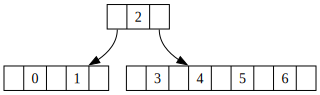

In [560]:
btree = ArbreB(2)
# btree.ajout(5)
# btree.ajout(11)
# btree.ajout(16)
# btree.ajout(21)
# btree.ajout(9)
for i in range(7):
    print("ajout de cle ",i)
    btree.ajout(i)

dot = visualiser_arbre(btree)
dot
# print(dot.source) 

# Arbres-B - Version 2
Sources : Sedgewick Wayne - Algorithms 4th edition

Avec clés sentinelles : pas de doublon de clés dans l'arbre mais copies de clés dans les noeuds internes pour guider la recherche.
- Noeuds internes : copie de clé + pages
- Noeuds externes : clé réelle

Pour un arbre d'ordre m avec m pair :
- Noeuds : m/2 <= k <= m-1 clés
- Racine : 2 <= k <= m-1 clés

## Arbre-B et PageB V2 <a class="anchor" id="btree2"></a>                                                                                                                                  
#### [Retour](#menu) 

In [561]:
def visualiser_arbre2(arbreB):
    dot = Digraph()
    index = 0

    def case(indice, estDerniereCle, cle=None):
        buffer = ""
        if cle is None:
            buffer += "<f" + str(indice) + "> "
        else:
            buffer += "<f" + str(indice) + "> " + str(cle)
        if estDerniereCle:
            buffer += "|"
        return buffer
    
    def traverse2(pageB):
        nonlocal index

        if pageB is None:
            return

        bufferRac = ""
        for i in range(len(arbreB.cles)):
            if i == len(arbreB.cles)-1 : # cas de la derniere cle
                bufferRac += case(len(arbreB.cles)-1, True, arbreB.cles[-1])
            else:
                bufferRac += case(i, False, arbreB.cles[i])
        dot.node(str(index), bufferRac)
        index += 1
        
        for i in range(len(arbreB.enfants)):
            traverse2(arbreB.enfants[i])
    
    traverse2(arbreB.racine)
    return dot

In [562]:
class PageB:
    def __init__(self, cles=[-1], estExterne=True):
        self.cles = cles # nbCles noeud : entre m/2 et m-1, nbCles racine : entre 2 et m-1
        self.enfants = []
        self.parent = None
        self.estExterne = estExterne

    def estPageExterne(self):
        return self.estExterne
    
    def estPagePleine(self, nbMaxCles):
        return len(self.cles) == nbMaxCles

    def estDansPage(self, cle):
        return cle in self.cles
    
    def pageSuivante(self, cle):
        """ Retourne la page suivante (enfant de la page self) qui pourrait
            contenir la cle cle.
            Hypothese : self n'est pas une page externe (sinon pas de page suivante)
        """
        assert not self.estExterne, "pageSuivante : page externe, pas de page suivante!"
        for i in range(len(self.enfants)):
            if cle < self.cles[i]:
                return self.enfants[i]
                
    def ajoutPageExterne(self, cle):
        """ Ajoute la cle cle dans la page externe self.
        """
        assert self.estPageExterne(), "ajoutPageExterne : pas une page externe!"
        self.cles.append(cle)
        self.cles.sort()

    def eclatement(self):
        """ Deplace la grande moitie des cles dans la page self vers une
            nouvelle page et retourne cette nouvelle page.
        """
        moitie = len(self.cles)//2
        petiteMoitie = self.cles[:moitie]
        grandeMoitie = self.cles[moitie:]
        self.cles = petiteMoitie
        return PageB(grandeMoitie)
    
    
class ArbreB:
    def __init__(self, ordre):
        assert ordre % 2 == 0, "Par convention, veuillez entrer un ordre pair!"
        self.racine = PageB()
        self.NBCLESMAX = ordre - 1
        
 
    def recherche(self, cle):
        """ Retourne vrai si cle est dans l'arbre-B self en
            cherchant dans les pagesB de l'arbre-B a l'aide
            de la fonction _recherche(pageB, cle).
        """
        return self._recherche(self.racine, cle)
    
    def _recherche(self, page:PageB, cle):
        """ Retourne vrai si la cle est dans l'arbre-B self en
            cherchant si la cle est dans une pageB de l'arbre.
        """
        if page.estPageExterne():
            return page.recherchePage(cle)
        else:
            return self._recherche(page.pageSuivante(cle), cle)
        

    def ajout(self, cle):
        if self.estVide():
            self.racine = PageB([cle])
            return
        else:
            self.racine.cles.append(cle)
            if self.racine.estPagePleine(self.NBCLESMAX):
                petiteMoitie = self.racine
                grandeMoitie = self.racine.eclatement()
                self.racine = PageB(petiteMoitie, False)
                self.racine.cles.extend(grandeMoitie)




